# 因子效力检验
接收已处理好的数据(列顺序为时间索引、被解释变量与因子)，输出投资建议表与相关检验信息(图)到指定路径  
三大步骤：  
1，加载与预处理数据  
2，选择模型   
3，评估表现

# 使用指南
1. 选择第二个cell(import cell)
2. 点击顶部菜单栏Cell--> Run All Below  
3. 回到第一个模块，设置好参数，最后run这一个cell即可

# 外部接口
要跑的函数

author: Siltka (Shi Yaoen)
update time: 2022/2/17

call load_data
test_size: 0.25
call split_data
call scale_X
n_splits: 3
call model_xgboost
run default xgboost model
param_grid: {'eta': [0.2, 0.25, 0.3, 0.35, 0.4], 'gamma': [0, 0.025, 0.05, 0.075, 0.01]}
run xgboost grid search
run best estimator
train_test_results: {'default_r2': array([0.27569353, 0.18659326, 0.29335475]), 'best_r2': [0.2284162204632019], 'best_params': [{'eta': 0.2, 'gamma': 0}], 'optimized_r2': [-0.24696090542706606]}
buy_signal: 0.03
call validate
get validate results


,default_r2,best_r2,best_params,optimized_r2,buy_point,single_return,accumulated_return,accumulated_win_rate,accumulated_loss_rate
0,0.275694,0.228416,"{'eta': 0.2, 'gamma': 0}",-0.246961,2020-04-20,-0.008140,-0.008140,0.000000,-0.008140
1,0.186593,NaN,NaN,NaN,2020-05-06,-0.018590,-0.026578,0.000000,-0.013289
2,0.293355,NaN,NaN,NaN,2020-05-07,-0.013888,-0.040097,0.000000,-0.013366
3,NaN,NaN,NaN,NaN,2020-05-08,-0.007623,-0.047414,0.000000,-0.011854
4,NaN,NaN,NaN,NaN,2020-06-03,0.008461,-0.039354,0.200000,-0.007871
...,...,...,...,...,...,...,...,...,...
64,NaN,NaN,NaN,NaN,2022-01-14,0.035419,0.317002,0.523077,0.004877
65,NaN,NaN,NaN,NaN,2022-01-17,0.029592,0.355975,0.530303,0.005394
66,NaN,NaN,NaN,NaN,2022-01-18,0.007642,0.366338,0.537313,0.005468
67,NaN,NaN,NaN,NaN,2022-01-20,-0.007063,0.356687,0.529412,0.005245


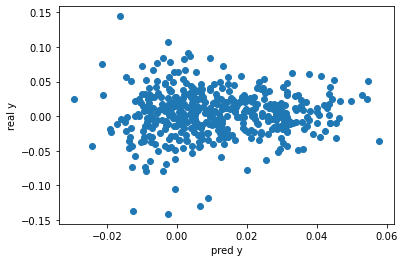

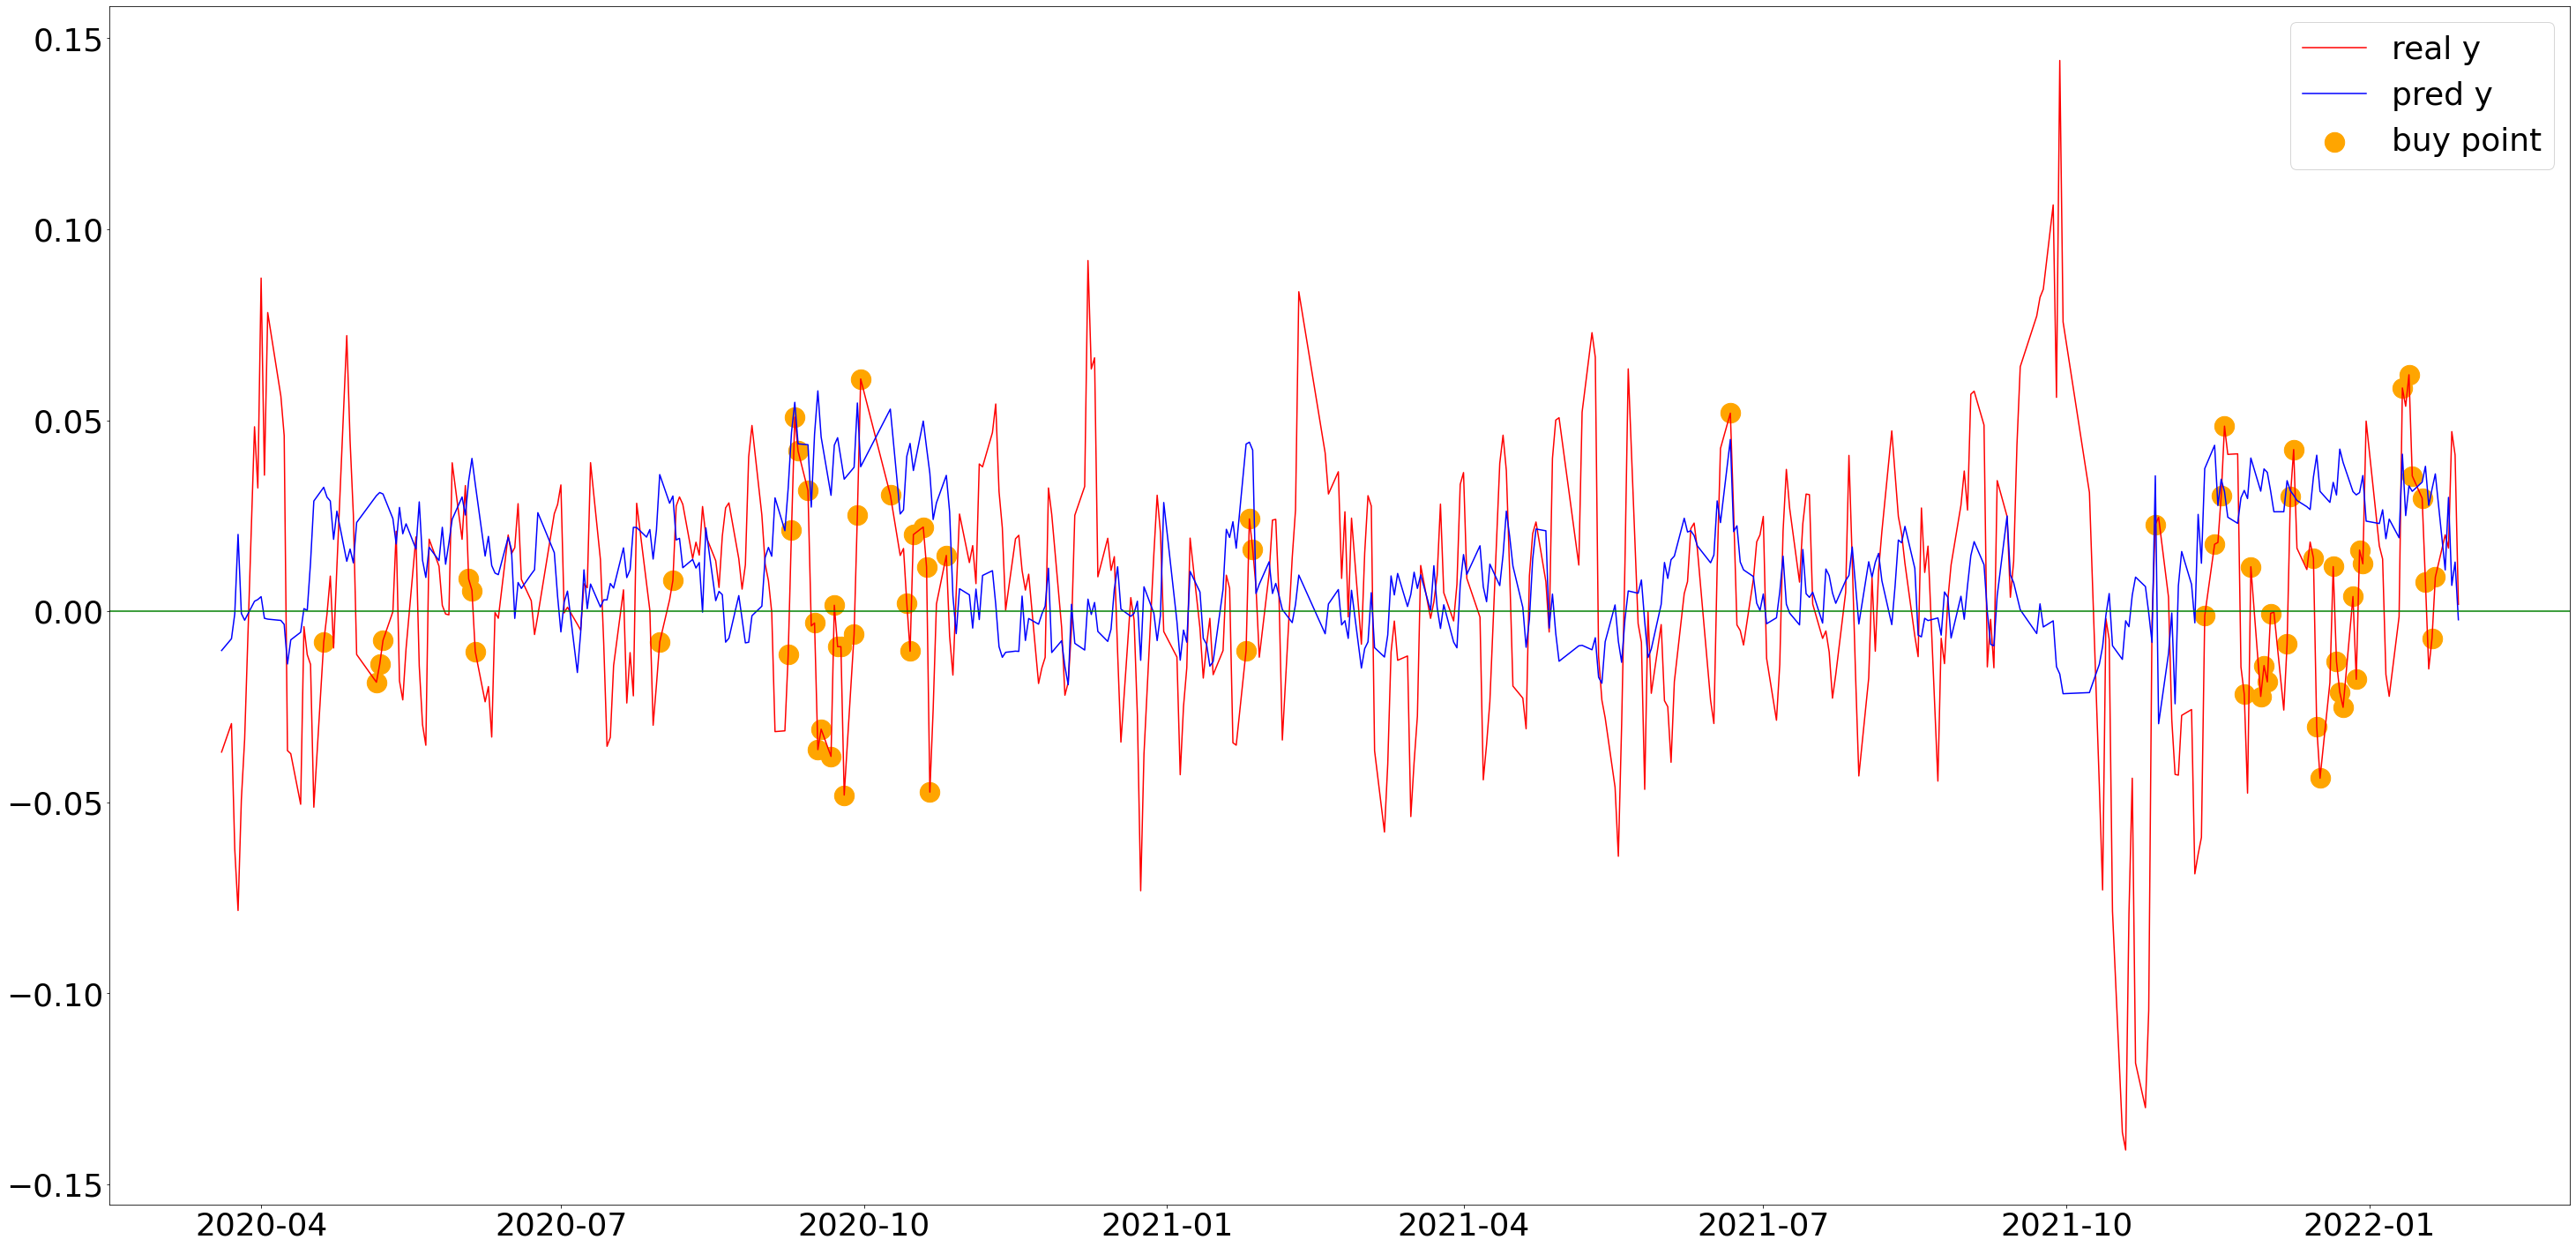

In [10]:
factor_evaluate(dataPath='C:/Users/ShaunMarx/实习_量化坊/03因子检验程序/ready_data.csv', 
                test_size=0.25, 
                buy_signal=0.03, 
                n_splits=3,
                outPath='C:/Users/ShaunMarx/实习_量化坊/03因子检验程序')

# import必要的库

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, GridSearchCV, KFold
from sklearn.metrics import r2_score

from xgboost.sklearn import XGBRegressor
from sklearn.neural_network import MLPRegressor

# define外部所调用的接口函数

In [2]:
def factor_evaluate(dataPath:str=None, model:str='xgboost', test_size:float=0.33, buy_signal:float=0.0, n_splits:int=5,
                   outPath:str=None):
    """
    数据格式要求：
    1，首列为可被pandas.DatetimeIndex所解析的时间，如YY-mm-dd格式
    2，第二列为被解释变量y
    3，其余列为因子X
    
    model可选取：xgboost
    """
    print('author: Siltka (Shi Yaoen)')
    print('update time: 2022/2/17')
    print()
    
    # 加载与预处理数据
    data = load_data(dataPath)
    X_tt, X_v, y_tt, y_v = split_data(data, test_size)
    X_tt_transformed, X_v_transformed = scale_X(X_tt, X_v)
    
    # 模型选择，返回预测结果:array和附带一个存储结果信息的dict
    if model == 'xgboost':
        y_v_pred, tt_results = model_xgboost(X_tt_transformed, X_v_transformed, y_tt, y_v, n_splits=n_splits)
    else:
        print('ERROR: please enter right model name.')
    
    # 将是array的预测结果带上日期索引，为了比较与画图
    y_v_pred = pd.Series(y_v_pred, index=y_v.index)
    
    draw_correlateplot(y_v, y_v_pred, outPath+'/correlateplot.png')
    
    # 评估在验证集中的表现
    validate_results = validate(y_v, y_v_pred, buy_signal, outPath)
    
    # 将两个results字典合并在一起并转换为DataFrame
    tt_results.update(validate_results)
    items = []
    for key, value in tt_results.items():
        items.append(pd.DataFrame({key: value}))
    
    df = pd.concat(items, axis=1)
    df.to_excel(outPath+'/invest_advice.xlsx')
    
    return df


# define内部被封装的函数

# 加载与预处理数据
首列为时间，第二列为标签，其余列为因子

In [3]:
def load_data(dataPath:str):
    
    print('call load_data')
    
    if dataPath.endswith('.csv'):
        data = pd.read_csv(dataPath, index_col=[0])
    elif dataPath.endswith('.xlsx'):
        data=pd.read_excel(dataPath, index_col=[0])
    else:
        print('ERROR: please enter correct file path.')
        return
    
    data.index = pd.DatetimeIndex(data.index)
    
    return data

In [4]:
def split_data(data:pd.DataFrame, test_size:float=0.33):
    
    # test
    print('test_size:',test_size)
    print('call split_data')
    
    X = data.iloc[:,1:]
    y = data.iloc[:,0]
    # 平稳性检验
    # 白噪声检验
    return train_test_split(X, y, test_size=test_size, shuffle=False)

In [5]:
def scale_X(X_tt:pd.DataFrame, X_v:pd.DataFrame):
    
    print('call scale_X')
    
    scaler = StandardScaler()
    return scaler.fit_transform(X_tt), scaler.transform(X_v)

# 模型构建
xgboost

## 1. xgboost

In [6]:
def model_xgboost(X_tt:pd.DataFrame, X_v:pd.DataFrame, y_tt:pd.Series, y_v:pd.Series, 
                  n_splits:int=5):
    
    # test
    print('n_splits:', n_splits)
    print('call model_xgboost')
    
    # 默认模型：
    print('run default xgboost model')
    cv0 = KFold(n_splits=n_splits, shuffle=True)
    default_r2 = cross_validate(XGBRegressor(), X_tt, y_tt, cv=cv0, scoring='r2', return_train_score=True)['test_score']
    
    # 网格搜索—优化参数
    
    param_grid = {
        'eta': [0.2, 0.25, 0.3, 0.35, 0.4], # learning rate
        'gamma': [0, 0.025, 0.05, 0.075, 0.01]  # min_split_loss
    }
    
    print('param_grid:', param_grid)
    
    print('run xgboost grid search')
    cv1 = KFold(n_splits=n_splits, shuffle=True)
    grid_search = GridSearchCV(XGBRegressor(), param_grid, scoring='r2', cv=cv1)
    grid_search.fit(X_tt, y_tt)

    # 得到优化超参的相关结果
    
    best_estimator = grid_search.best_estimator_
    best_r2 = grid_search.best_score_
    best_params = grid_search.best_params_
    
    # 用最佳模型再做一次拟合
    
    print('run best estimator')
    y_v_pred = best_estimator.predict(X_v)
    optimized_r2 = r2_score(y_v, y_v_pred)
    
    # 返回结果
    
    tt_results = {
        'default_r2': default_r2,
        'best_r2': [best_r2],
        'best_params': [best_params],
        'optimized_r2': [optimized_r2]
    }
    
    print('train_test_results:', tt_results)
    
    return y_v_pred, tt_results

# 结果评判

In [7]:
def validate(y_real:pd.Series, y_pred:pd.Series, buy_signal:float, figOutPath:str):
    
    # test
    print('buy_signal:', buy_signal)
    print('call validate')
    
    if len(y_real) != len(y_pred):
        print('the length of real y and pred y are not equal.')
        return
    
    y_real_array = y_real.values
    
    time_index = y_real.index
    
    win = 0
    buy_days = 0
    accu_ret = 0
    
    buy_points = []
    single_return = []
    accumulated_returns = []
    accumulated_win_rates = []
    accumulated_loss_rates = []
    
    # 优化：n日收益率与单日收益率的区分
    for i in range(len(y_real)):
        if y_pred[i] > buy_signal: 
            buy_days += 1
            buy_point = time_index[i]
            accu_ret = (1 + accu_ret) * ( 1 + y_real[i] ) - 1
            if y_real[i] > 0:
                win += 1
            
            buy_points.append(buy_point)
            
            # test
            single_return.append(y_real_array[i])
            accumulated_returns.append(accu_ret)
            accumulated_win_rates.append( win / buy_days )
            accumulated_loss_rates.append( accu_ret / buy_days)
    
    validate_results = {
        'buy_point': buy_points,
        'single_return': single_return,
        'accumulated_return': accumulated_returns,
        'accumulated_win_rate': accumulated_win_rates,
        'accumulated_loss_rate': accumulated_loss_rates
    }
    
    draw_buyplot(y_real, y_pred, time_index, buy_points, figOutPath+'/buyplot.png')
    # 优化：draw buy & sell plot
    
    print('get validate results')
    
    return validate_results

In [8]:
def draw_correlateplot(y_real:pd.Series, y_pred:pd.Series, figOutPath:str):
    
    plt.scatter(y_pred, y_real)
    plt.ylabel('real y')
    plt.xlabel('pred y')
    plt.savefig(figOutPath)

In [9]:
def draw_buyplot(y_real:pd.Series, y_pred:pd.Series, time_index:pd.DatetimeIndex, buy_points:pd.DatetimeIndex, figOutPath:str):
    
    plt.figure(figsize=(50, 25))
    
    plt.plot(time_index, y_real, label='real y', color='red')
    plt.plot(time_index, y_pred, label='pred y', color='blue')
    plt.axhline(y=0, color='green')
    plt.scatter(buy_points, y_real.loc[buy_points], label='buy point', s=500, color='orange')

    plt.legend(fontsize = 36)
    plt.xticks(fontsize=36)
    plt.yticks(fontsize=36)

    plt.savefig(figOutPath)